**NLP (Natural Language Processing)**

This is the notebook that goes along with the NLP video lecture!

In this lecture we will discuss a higher level overview of the basics of Natural Language Processing, which basically consists of combining machine learning techniques with text, and using math and statistics to get that text in a format that the machine learning algorithms can understand!

In this lecture we will go over:

Part 1: Data

Part 2: Basic Exploratory Data Analysis

Part 3: Text Pre-Processing

Part 4: Vectorization

Part 6: Model Evaluation

Part 7: Creating a Data Pipeline

In [ ]:
import nltk
nltk.download()

https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

The file we are using contains a collection of more than 5 thousand SMS phone messages. You can check out the readme file for more info.

Let's go ahead and use rstrip() plus a list comprehension to get a list of all the lines of text messages:

In [1]:
messages = [line.rstrip() for line in open('smsspamcollection/SMSSpamCollection')]
print len(messages)

5574


In [2]:
for message_no, message in enumerate(messages[:10]):
    print message_no, message
    print '\n'

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


1 ham	Ok lar... Joking wif u oni...


2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


3 ham	U dun say so early hor... U c already then say...


4 ham	Nah I don't think he goes to usf, he lives around here though


5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv


6 ham	Even my brother is not like to speak with me. They treat me like aids patent.


7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune


8 spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code 

Due to the spacing we can tell that this is a TSV ("tab separated values") file, where the first column is a label saying whether the given message is a normal message (commonly known as "ham") or "spam". The second column is the message itself. (Note our numbers aren't part of the file, they are just from the enumerate call).

Using these labeled ham and spam examples, we'll train a machine learning model to learn to discriminate between ham/spam automatically. Then, with a trained model, we'll be able to classify arbitrary unlabeled messages as ham or spam.

From the official SciKit Learn documentation, we can visualize our process:



<img src="http://www.astroml.org/sklearn_tutorial/_images/plot_ML_flow_chart_3.png">

In [3]:
import pandas

In [4]:
messages = pandas.read_csv('smsspamcollection/SMSSpamCollection', sep='\t',
                           names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [6]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
label      5572 non-null object
message    5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


In [7]:
messages.groupby('label').describe()

message
label                                                          
ham   count                                                4825
      unique                                               4516
      top                                Sorry, I'll call later
      freq                                                   30
spam  count                                                 747
      unique                                                653
      top     Please call our customer service representativ...
      freq                                                    4

As we continue our analysis we want to start thinking about the features we are going to be using. This goes along with the general idea of feature engineering. The better your domain knowledge on the data, the better your ability to engineer more features from it. Feature engineering is a very large part of spam detection in general. I encourage you to read up on the topic!

Let's make a new column to detect how long the text messages are:

In [8]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

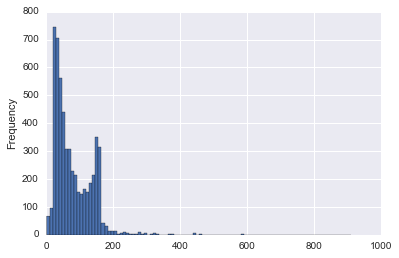

In [12]:
messages['length'].plot(bins=100, kind='hist') 

In [13]:
messages.length.describe()

count    5572.000000
mean       80.616296
std        60.015593
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

In [14]:
messages[messages['length'] == 910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000B443908>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000D6A05C0>], dtype=object)

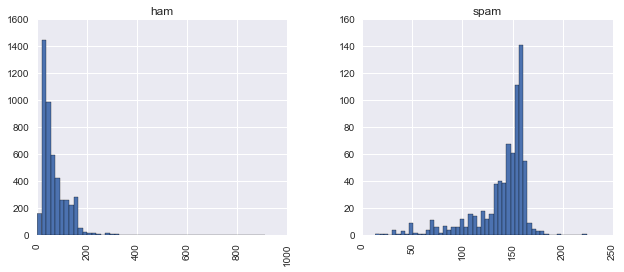

In [19]:
messages.hist(column='length', by='label', bins=50,figsize=(10,4))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000B73E4E0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000E1A1080>], dtype=object)

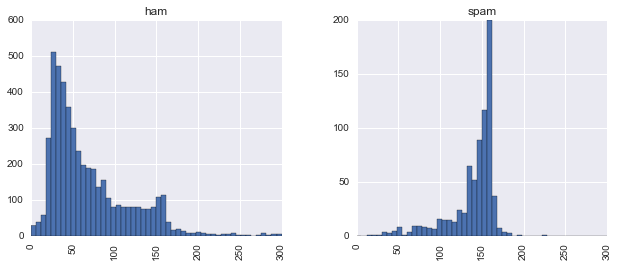

In [20]:
#resize to see ham better
messages.hist(column='length', by='label', range = [0,300], bins=50,figsize=(10,4))

**Text pre-processing**

Our main issue with our data is that it is all in text format (strings). The classification algorithms that we've learned about so far will need some sort of numerical feature vector in order to perform the classification task. There are actually many methods to convert a corpus to a vector format. The simplest is the the bag-of-words approach, where each unique word in a text will be represented by one number.

In this section we'll massage the raw messages (sequence of characters) into vectors (sequences of numbers).

As a first step, let's write a function that will split a message into its individual words and return a list. We'll also remove very common words, ('the', 'a', etc..). To do this we will take advantage of the NLTK library. It's pretty much the standard library in Python for processing text and has a lot of useful features. We'll only use some of the basic ones here.

Let's create a function that will process the string in the message column, then we can just use apply() in pandas do process all the text in the DataFrame.

First removing punctuation. We can just take advantage of Python's built-in string library to get a quick list of all the possible punctuation:

In [16]:
import string

mess = 'Sample message! Notice: it has punctuation.'

# Check characters to see if they are in punctuation
nopunc = [char for char in mess if char not in string.punctuation]

# Join the characters again to form the string.
nopunc = ''.join(nopunc)

In [17]:
from nltk.corpus import stopwords
stopwords.words('english')[0:10] # Show some stop words

[u'i',
 u'me',
 u'my',
 u'myself',
 u'we',
 u'our',
 u'ours',
 u'ourselves',
 u'you',
 u'your']

In [21]:
# Now just remove any stopwords
clean_mess = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [22]:
clean_mess

['Sample', 'message', 'Notice', 'punctuation']

In [23]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [24]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [26]:
messages['message'].head().apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

**Continuing Normalization**

There are a lot of ways to continue normalizing this text. Such as Stemming or distinguishing by part of speech.

NLTK has lots of built-in tools and great documentation on a lot of these methods. Sometimes they don't work well for text-messages due to the way a lot of people tend to use abbreviations or shorthand, For example:

'Nah dawg, IDK! Wut time u headin to da club?'

versus

'No dog, I don't know! What time are you heading to the club?'

Some text normalization methods will have trouble with this type of shorthand and so I'll leave you to explore those more advanced methods through the NLTK book online.

For now we will just focus on using what we have to convert our list of words to an actual vector that SciKit-Learn can use.

**Vectorization**

Currently, we have the messages as lists of tokens (also known as lemmas) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

We'll do that in three steps using the bag-of-words model:

Count how many times does a word occur in each message (Known as term frequency)

Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

Let's begin the first step:

Each vector will have as many dimensions as there are unique words in the SMS corpus. We will first use SciKit Learn's CountVectorizer. This model will convert a collection of text documents to a matrix of token counts.

We can imagine this as a 2-Dimensional matrix. Where the 1-dimension is the entire vocabulary (1 row per word) and the other dimension are the actual documents, in this case a column per text message.

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

In [29]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])

# Print total number of vocab words
print len(bow_transformer.vocabulary_)

C:\Users\yanke_000\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


11425


In [30]:
message4 = messages['message'][3]
print message4

U dun say so early hor... U c already then say...


In [31]:
bow4 = bow_transformer.transform([message4])
print bow4
print bow4.shape

  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2
(1, 11425)


In [33]:
print bow_transformer.get_feature_names()[4068]
print bow_transformer.get_feature_names()[9554]

U
say


In [34]:
messages_bow = bow_transformer.transform(messages['message'])
print 'Shape of Sparse Matrix: ', messages_bow.shape
print 'Amount of Non-Zero occurences: ', messages_bow.nnz
print 'sparsity: %.2f%%' % (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))

C:\Users\yanke_000\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


Shape of Sparse Matrix:  (5572, 11425)
Amount of Non-Zero occurences:  50548
sparsity: 0.08%


After the counting, the term weighting and normalization can be done with TF-IDF, using scikit-learn's TfidfTransformer.

**So what is TF-IDF?**

TF-IDF stands for term frequency-inverse document frequency, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.

One of the simplest ranking functions is computed by summing the tf-idf for each query term; many more sophisticated ranking functions are variants of this simple model.

Typically, the tf-idf weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

TF: Term Frequency, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization:

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).

IDF: Inverse Document Frequency, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following:

IDF(t) = log_e(Total number of documents / Number of documents with term t in it).

See below for a simple example.

Example:

Consider a document containing 100 words wherein the word cat appears 3 times.

The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word cat appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12.

In [35]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print tfidf4

  (0, 9554)	0.538562626293
  (0, 7186)	0.438936565338
  (0, 6222)	0.318721689295
  (0, 6204)	0.299537997237
  (0, 5261)	0.297299574059
  (0, 4629)	0.266198019061
  (0, 4068)	0.408325899334


In [36]:
print tfidf_transformer.idf_[bow_transformer.vocabulary_['u']]
print tfidf_transformer.idf_[bow_transformer.vocabulary_['university']]

3.28005242674
8.5270764989


In [37]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print messages_tfidf.shape

(5572, 11425)


**Training a model**

With messages represented as vectors, we can finally train our spam/ham classifier. Now we can actually use almost any sort of classification algorithms. For a variety of reasons, the Naive Bayes classifier algorithm is a good choice.

In [38]:
from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(messages_tfidf, messages['label'])

In [39]:
print 'predicted:', spam_detect_model.predict(tfidf4)[0]
print 'expected:', messages.label[3]

predicted: ham
expected: ham


In [40]:
all_predictions = spam_detect_model.predict(messages_tfidf)
print all_predictions

['ham' 'ham' 'spam' ..., 'ham' 'ham' 'ham']


We can use SciKit Learn's built-in classification report, which returns precision, recall, f1-score, and a column for support (meaning how many cases supported that classification). Check out the links for more detailed info on each of these metrics and the figure below:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png">

In [42]:
from sklearn.metrics import classification_report
print classification_report(messages['label'], all_predictions)

             precision    recall  f1-score   support

        ham       0.98      1.00      0.99      4825
       spam       1.00      0.85      0.92       747

avg / total       0.98      0.98      0.98      5572



There are quite a few possible metrics for evaluating model performance. Which one is the most important depends on the task and the business effects of decisions based off of the model. For example, the cost of mispredicting "spam" as "ham" is probably much lower than mispredicting "ham" as "spam".

In the above "evaluation",we evaluated accuracy on the same data we used for training. You should never actually evaluate on the same dataset you train on!

Such evaluation tells us nothing about the true predictive power of our model. If we simply remembered each example during training, the accuracy on training data would trivially be 100%, even though we wouldn't be able to classify any new messages.

A proper way is to split the data into a training/test set, where the model only ever sees the training data during its model fitting and parameter tuning. The test data is never used in any way. This is then our final evaluation on test data is representative of true predictive performance.

In [43]:
from sklearn.cross_validation import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(messages['message'], messages['label'], test_size=0.2)

print len(msg_train), len(msg_test), len(msg_train) + len(msg_test)

4457 1115 5572


The test size is 20% of the entire dataset (1115 messages out of total 5572), and the training is the rest (4457 out of 5572). Note the default split would have been 30/70.

**Creating a Data Pipeline**

Let's run our model again and then predict off the test set. We will use SciKit Learn's pipeline capabilities to store a pipline of workflow. This will allow us to set up all the transformations that we will do to the data for future use. Let's see an example of how it works:

In [44]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [46]:
pipeline.fit(msg_train,label_train)

C:\Users\yanke_000\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


Pipeline(steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x000000000E230898>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preproces...         use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [47]:
predictions = pipeline.predict(msg_test)

C:\Users\yanke_000\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [48]:
print classification_report(predictions,label_test)

             precision    recall  f1-score   support

        ham       1.00      0.96      0.98      1014
       spam       0.71      1.00      0.83       101

avg / total       0.97      0.96      0.97      1115



Now we have a classification report for our model on a true testing set! There is a lot more to Natural Language Processing than what we've covered here, and its vast expanse of topic could fill up several college courses! I encourage you to check out the resources below for more information on NLP!

**See Portilla notebook for more resource**